# ASHRAE - Great Energy Predictor III¶

This notebook contains basic exploration of provided data and creation of recurent neural network model with tensorflow. <br>This it was kept in a simple manner in order to provide base line solution for LSTM.
<br><br>

_Context_

With advancements in technology and increasing number of people world wide also the amount of energy is rising. To prevent negative impact of this growth we could find possibilities to optimize the energy consumed by buildings. In order to do that there is required some insights into "energetic efficiency" of buildings.

In [1]:
!pip install tensorflow==2.0.0
!pip install chart_studio

import numpy as np 
import pandas as pd
import os

import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm

import math
import random

     |████████████████████████████████| 86.3MB 187kB/s 
     |████████████████████████████████| 3.8MB 30.3MB/s 
     |████████████████████████████████| 450kB 43.1MB/s 
     |████████████████████████████████| 71kB 18.3MB/s 
     |████████████████████████████████| 153kB 41.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bdda40b611c441de2e8ebb9d1ff3edc5589e525d2aa3110639e95a03bfbbf9bc
  Stored in directory: /tmp/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp36-none-any.whl size=61682 sha256=16cdd4676b832ed661a4b32e865882c2afc1ae4a1fc30916e5a859b7d9e6302a
  Stored in directory: /tmp/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Successfully built gast opt-einsum
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.24.0 which is incompatible.
  Found existing installation: gast 0.3.2
    Uninstalling 

### Preprocessing

We've following files for exploration.

In [2]:
!ls ../input/ashrae-energy-prediction/

building_metadata.csv  test.csv   weather_test.csv
sample_submission.csv  train.csv  weather_train.csv


Let's start analysis from the reading datasets.

In [3]:
%%time
train_df = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
weather_train_df = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
test_df = pd.read_csv('../input/ashrae-energy-prediction/test.csv')
weather_test_df = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')
building_meta_df = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')

CPU times: user 27.3 s, sys: 8.85 s, total: 36.2 s
Wall time: 35.8 s


In [4]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [5]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [6]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [7]:
weather_test_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [8]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [9]:
train_df = train_df.merge(building_meta_df, on="building_id")

In [10]:
train_df = train_df.merge(weather_train_df, on=["site_id", "timestamp"])

Let's take a look at sample rows from combined dataframe.

In [11]:
sample_df = train_df.sample(20, random_state=0)
sample_df

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
2217631,255,3,2016-03-26 07:00:00,8.7921,2,Education,49078,1914.0,NaN,21.7,4.0,-6.7,0.0,1004.8,280.0,1.5
14843430,1209,0,2016-08-13 19:00:00,236.1380,13,Healthcare,115788,NaN,NaN,25.6,NaN,15.6,0.0,1012.9,320.0,5.7
17098627,1250,0,2016-06-27 17:00:00,664.5210,14,Education,232139,NaN,NaN,27.8,0.0,13.9,0.0,1016.9,190.0,3.6
10198113,888,2,2016-03-16 07:00:00,314.1500,9,Entertainment/public assembly,137522,NaN,NaN,19.4,0.0,6.1,0.0,1013.4,NaN,1.5
15314118,1102,2,2016-10-16 08:00:00,2609.3800,13,Office,87187,NaN,NaN,8.3,2.0,6.7,0.0,1011.6,0.0,0.0
15639128,1119,0,2016-11-29 04:00:00,52.0000,13,Office,119509,NaN,NaN,3.9,4.0,-0.6,0.0,982.4,230.0,2.6
8677154,765,0,2016-12-08 09:00:00,155.3670,6,Entertainment/public assembly,58562,NaN,NaN,2.2,NaN,0.0,0.0,1016.4,0.0,0.0
13837181,1150,1,2016-03-30 23:00:00,0.0000,13,Office,196043,NaN,NaN,7.8,NaN,4.4,0.0,1002.1,20.0,5.1
3671275,246,0,2016-10-22 10:00:00,351.8000,2,Office,202435,1967.0,NaN,25.0,0.0,5.6,0.0,1009.2,110.0,2.6
17242887,1244,0,2016-07-18 19:00:00,113.6400,14,Public services,95526,NaN,NaN,33.3,0.0,17.8,0.0,1015.7,250.0,5.1


Now let's change the 'primary_use' column to categorical.

In [12]:
train_df['primary_use'] = pd.Categorical(train_df['primary_use'])
train_df['primary_use'] = train_df['primary_use'].cat.codes
train_df.head(10)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
5,5,0,2016-01-01 00:00:00,0.0,0,0,8000,2000.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
6,6,0,2016-01-01 00:00:00,0.0,0,4,27926,1981.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
7,7,0,2016-01-01 00:00:00,0.0,0,0,121074,1989.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
8,8,0,2016-01-01 00:00:00,0.0,0,0,60809,2003.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
9,9,0,2016-01-01 00:00:00,0.0,0,6,27000,2010.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


Let's check how many 'NaN' values has each column.

In [13]:
train_df.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12113306
floor_count           16630052
air_temperature           6163
cloud_coverage         8734870
dew_temperature           9645
precip_depth_1_hr      3658528
sea_level_pressure     1141174
wind_direction         1358553
wind_speed               53181
dtype: int64

In [14]:
100 * train_df.isnull().sum() / len(train_df)

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            60.188531
floor_count           82.631315
air_temperature        0.030623
cloud_coverage        43.401776
dew_temperature        0.047924
precip_depth_1_hr     18.178475
sea_level_pressure     5.670259
wind_direction         6.750371
wind_speed             0.264245
dtype: float64

As we can see there is quite lot of NaN's in some of the columns. In order to use the this data in neural network we have to change them into numerical values or drop them.

In [15]:
del train_df['floor_count']
del train_df['year_built']

### Shaping data
In order to run LSTM neural network data has to be in three dimentional shape where axis corresponds to following data:
* x-axis time steps
* y-axis data examples
* z-axis features for single point in time

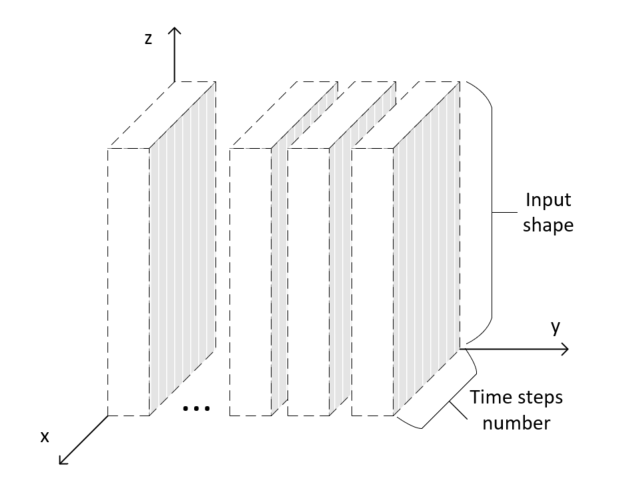

There are fine written resources on the net describing how LSTM networks works and what's their architecture.
* i.e. [here](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Let's take data for first 10 building_id's and preprocess them for LSTM neural network.

In [16]:
def extract_data(building_id):
    return train_df[train_df['building_id'] == building_id]

extracted_df = {}
for i in range(10):
    df = extract_data(i)
    sea_lev_pressure_mean = df['sea_level_pressure'].mean()
    dew_temperature_mean = df['dew_temperature'].mean()
    air_temperature_mean = df['air_temperature'].mean()
    precip_depth_1_hr_mean = df['precip_depth_1_hr'].mean()
    wind_speed_mean = df['wind_speed'].median()

    df['meter'] = pd.to_numeric(df['meter'], errors='coerce').fillna(0).astype(np.float32)
    df['meter_reading'] = pd.to_numeric(df['meter_reading'], errors='coerce').fillna(0).astype(np.float32)
    df['site_id'] = pd.to_numeric(df['site_id'], errors='coerce').fillna(0).astype(np.float32)
    df['primary_use'] = pd.to_numeric(df['primary_use'], errors='coerce').fillna(0).astype(np.float32)
    df['square_feet'] = pd.to_numeric(df['square_feet'], errors='coerce').fillna(0).astype(np.float32)
    
    df['air_temperature'] = df['air_temperature'].fillna(-1)
    df['cloud_coverage'] = df['cloud_coverage'].fillna(-1)
    df['sea_level_pressure'] = df['sea_level_pressure'].fillna(sea_lev_pressure_mean)
    df['dew_temperature'] = df['dew_temperature'].fillna(dew_temperature_mean)
    df['air_temperature'] = df['air_temperature'].fillna(air_temperature_mean)
    df['precip_depth_1_hr'] = df['precip_depth_1_hr'].fillna(precip_depth_1_hr_mean)
    df['wind_direction'] = df['wind_direction'].apply(lambda x: random.random() * 360.0 if (math.isnan(x)) else x)
    df['wind_speed'] = df['wind_speed'].fillna(wind_speed_mean).astype(np.float32)
    extracted_df[i] = df
    
extracted_df[4]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
4,4,0.0,2016-01-01 00:00:00,0.000000,0.0,0.0,116607.0,25.0,6.0,20.0,1.382557,1019.7,0.0,0.0
107,4,0.0,2016-01-01 01:00:00,0.000000,0.0,0.0,116607.0,24.4,-1.0,21.1,-1.000000,1020.2,70.0,1.5
210,4,0.0,2016-01-01 02:00:00,0.000000,0.0,0.0,116607.0,22.8,2.0,21.1,0.000000,1020.2,0.0,0.0
313,4,0.0,2016-01-01 03:00:00,0.000000,0.0,0.0,116607.0,21.1,2.0,20.6,0.000000,1020.1,0.0,0.0
416,4,0.0,2016-01-01 04:00:00,0.000000,0.0,0.0,116607.0,20.0,2.0,20.0,-1.000000,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076026,4,0.0,2016-12-31 19:00:00,1150.800049,0.0,0.0,116607.0,22.8,-1.0,10.0,0.000000,1021.7,140.0,5.7
1076154,4,0.0,2016-12-31 20:00:00,1197.890015,0.0,0.0,116607.0,23.3,-1.0,8.9,0.000000,1021.0,170.0,4.1
1076282,4,0.0,2016-12-31 21:00:00,1147.380005,0.0,0.0,116607.0,23.3,-1.0,10.0,0.000000,1021.1,150.0,4.1
1076410,4,0.0,2016-12-31 22:00:00,1130.319946,0.0,0.0,116607.0,22.8,-1.0,10.0,0.000000,1021.1,160.0,3.1


Dictionary 'extracted_df' contains data for buildings_ids in range \[0, 10) which have to be reshaped in order to feed them into LSTM neural network.

In [17]:
### Building simple LSTM network

In [18]:
def input_function(x_tr, y_tr, x_d, y_d, x_t, y_t, bs_tr):
    t_d = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    t_d = t_d.cache().batch(bs_tr).repeat()
    d_d = tf.data.Dataset.from_tensor_slices((x_d, y_d))
    d_d = d_d.batch(bs_tr).repeat()
    v_d = tf.data.Dataset.from_tensor_slices((x_t, y_t))
    v_d = v_d.batch(1).repeat()
    return t_d, d_d, v_d

Splits data according to provided parameters.

In [19]:
def split_data(ds, tar, st_ind, en_ind, hs,
               ts, step):
    data = []
    lab = []

    st_ind = st_ind + hs
    if en_ind is None:
        en_ind = len(ds) - ts

    for i in range(st_ind, en_ind):
        indices = range(i - hs, i, step)
        data.append(ds[indices])
        lab.append(tar[i + ts])

    return np.array(data), np.array(lab)

Prepares data for three sets of data (train, dev, val) for every 'building_id'.

In [20]:
def prepare_data(data, hn, tv_split,
                 ve_split, tn, step=1, bs=64):
    ds = {}

    for j in range(10):
        x_tr, y_tr = split_data(data[j], data[j][:, 3], 0,
                                          tv_split, hn,
                                          tn, step)
        x_d, y_d = split_data(data[j], data[j][:, 3],
                                      tv_split, ve_split, hn,
                                      tn, step)
        x_t, y_t = split_data(data[j], data[j][:, 3],
                                        ve_split, None, hn,
                                        tn, step)
        t_d, d_d, v_d = input_function(x_tr, y_tr, x_d, y_d, x_t, y_t, bs)
        ds[j] = {}
        ds[j]['train'] = t_d
        ds[j]['dev'] = d_d
        ds[j]['test'] = v_d

    inp_d = x_tr.shape[-2:]

    return inp_d, ds

Standardize features by removing mean and scaling according to variances.

In [21]:
def scale_data(data_dict, fc, fc_n):
    td = {}
    norm_param = {}

    for i in range(10):
        norm_param[i] = {}
        features = data_dict[i][fc]
        features.index = data_dict[i]['timestamp']
        features.head()
        for j in fc_n:
            data_mean = features[j].mean(axis=0)
            data_std = features[j].std(axis=0)
            features[j] = (features[j] - data_mean) / data_std
        td[i] = features.values
    
    return td, norm_param
        


Fit to every data set with given 'building_id'.

In [22]:
def fit_model(ds, model, eval_int, epochs=10, trg='meter'):
    tm_histories = {}
    for i in range(10):
        print("Fitting to %s" % i)
        tm_histories[i] = model.fit(ds[i]["train"],
                                   validation_data=ds[i]["dev"],
                                   steps_per_epoch=eval_int,
                                   epochs=epochs,
                                   validation_steps=1).history
    return model, tm_histories

Here we prepare data using previously defined functions

In [23]:
fc = ['meter', 'meter_reading', 'site_id',
      'primary_use', 'air_temperature', 'cloud_coverage',
      'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
      'wind_direction', 'wind_speed']

fc_n = ['meter_reading','air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed']

tv_split = int(len(extracted_df[4])* 0.7)
ve_split = int(len(extracted_df[4])* 0.85)
past = 30
eval_int = 1

td_set, norm_params = scale_data(extracted_df, fc, fc_n)
# print(td_set[1][:10])
inp_d, ds = prepare_data(td_set, past, tv_split, ve_split, 1, step=1, bs=32)



Bellow we create LSTM model with tensorflow keras. Sample loss function is doesn't complie with the one provided in the task yet.

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=30,
                               return_sequences=True,
                               input_shape=inp_d))
model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.LSTM(units=16, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.8))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0), loss='mse')

In [25]:
# model, hist_dict = fit_model(ds, model, eval_int, 500)

### Further analysis
Comming soon ...